In [13]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
# import mytools

In [33]:
from shapely.geometry import Polygon,Point,LineString
import matplotlib.pyplot as plt
from descartes import PolygonPatch

### 用样方将多边形切割成亚多边形

In [15]:
data = pd.read_csv('G:/1-规划/1其他工作输出/备份/2020年备份/20200303数据按照栅格进行圈选/漫游清单2.csv',encoding='gbk')

In [16]:
df = data.copy()
df['geometry'] = [Point(x) for x in zip(df['经度'], df['纬度'])]
data_p = gpd.GeoDataFrame(df, crs={"init": "epsg:4326"}, geometry='geometry') 

In [17]:
a = data_p.total_bounds

In [18]:
quyu = Polygon(((a[0],a[1]),(a[0],a[3]),(a[2],a[3]),(a[2],a[1]),(a[0],a[1])))

In [19]:
test_dict = {'geometry':quyu}

In [20]:
data_f=pd.DataFrame(test_dict,index=[1])

In [21]:
gdf = gpd.GeoDataFrame(data_f, crs={"init": "epsg:4326"}, geometry='geometry') 

In [22]:
gdf2 = gdf.to_crs({'init': 'epsg:32650'})

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [23]:
a2=gdf2['geometry'][1]

In [27]:

def _quadrat_cut_geometry(geometry, quadrat_width, min_num=3, buffer_amount=1e-9):
    """
    Split a Polygon or MultiPolygon up into sub-polygons of a specified size.
    Parameters
    ----------
    geometry : shapely.geometry.Polygon or shapely.geometry.MultiPolygon
        the geometry to split up into smaller sub-polygons
    quadrat_width : numeric
        the linear width of the quadrats with which to cut up the geometry (in
        the units the geometry is in)
    min_num : int
        the minimum number of linear quadrat lines (e.g., min_num=3 would
        produce a quadrat grid of 4 squares)
    buffer_amount : numeric
        buffer the quadrat grid lines by quadrat_width times buffer_amount
    Returns
    -------
    multipoly : shapely.geometry.MultiPolygon
    """
    # create n evenly spaced points between the min and max x and y bounds
    west, south, east, north = geometry.bounds
    x_num = math.ceil((east - west) / quadrat_width) + 1
    y_num = math.ceil((north - south) / quadrat_width) + 1
    x_points = np.linspace(west, east, num=max(x_num, min_num))
    y_points = np.linspace(south, north, num=max(y_num, min_num))

    # create a quadrat grid of lines at each of the evenly spaced points
    vertical_lines = [LineString([(x, y_points[0]), (x, y_points[-1])]) for x in x_points]
    horizont_lines = [LineString([(x_points[0], y), (x_points[-1], y)]) for y in y_points]
    lines = vertical_lines + horizont_lines

    # buffer each line to distance of the quadrat width divided by 1 billion,
    # take their union, then cut geometry into pieces by these quadrats
    buffer_size = quadrat_width * buffer_amount
    lines_buffered = [line.buffer(buffer_size) for line in lines]
    quadrats = unary_union(lines_buffered)
    multipoly = geometry.difference(quadrats)
    return multipoly


In [35]:
import math
import numpy as np
from shapely.ops import unary_union

In [36]:
geometry_cut = _quadrat_cut_geometry(a2, quadrat_width=1000)

In [37]:
west, south, east, north = list(a2.bounds) #方框赋值变量

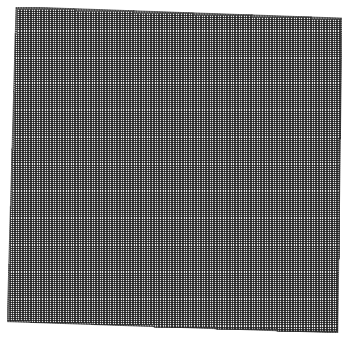

In [38]:
# plot the city  显示
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west-0.1, east+0.1)
ax.set_ylim(south-0.1, north+0.1)
ax.axis('off')
plt.show()

In [39]:
grid = []
for polygon in geometry_cut:
    grid.append(polygon)

In [40]:
grid_df=pd.DataFrame(grid,columns=['geome'])

In [41]:
grid_gdf = gpd.GeoDataFrame(grid_df, crs={"init": "epsg:32650"}, geometry='geome') 

In [42]:
grid_gdf2 = grid_gdf.to_crs({'init': 'epsg:4326'})

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [43]:
grid_gdf3 = grid_gdf2.reset_index()

In [44]:
grid_gdf3.columns = ['grid', 'geome']

In [45]:
res = gpd.sjoin(grid_gdf3,data_p)

In [46]:
res1 = res[['grid', 'ECI', '漫游进来的用户数', '等级', '小区中文名',
       '所属eNodeB名称', '上行PRB平均利用率', '下行PRB平均利用率', '保障场景', '经度', '纬度', '方位角',
       '天线挂高', '所属地区', '厂家名称', '频点', '频段1分层', '覆盖类别', '覆盖场景', '覆盖场景.1']]

In [47]:
res1.to_csv('d:/data_2000.csv',encoding='gbk',index=False)

In [48]:
res.to_file('d:/m500.geojson', driver="GeoJSON", encoding='gbk')

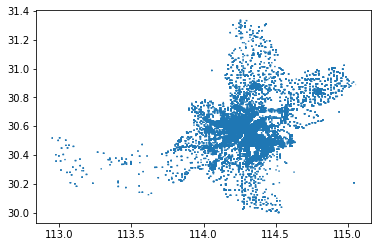

In [49]:
res.plot()